In [1]:
# import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec as gspec
import matplotlib.colors as mcolors

In [2]:
gis_data = pd.read_csv("gisaid_parsed.tsv", sep='\t')
gis_data["State"] = gis_data['State'].replace({"Baltimore":"Maryland"})
gis_data["State"].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Maryland',
       'California', 'Colorado', 'Delaware', 'Indiana', 'Massachusetts',
       'Oregon'], dtype=object)

In [3]:
# Load GISAID data and select desired columns, exclude alaska
lineage_data = gis_data[["State", "Lineage"]]
lineage_data = lineage_data[lineage_data["State"] != "Alaska"]
lineage_data.head()

,State,Lineage
0,Alabama,IIb B.1.2
1,Alabama,IIb B.1.2
2,Alabama,IIb B.1.7
5,Arizona,IIb B.1
6,Arizona,IIb B.1


In [5]:
# Specify colors for pie plot
colors = dict(zip(lineage_data["Lineage"].unique(), mcolors.TABLEAU_COLORS.values()))

# Get proportion of each lineage in each state
lineage_counts = lineage_data.value_counts(["State", "Lineage"]).reset_index().groupby("State").agg(list)
lineage_counts.columns = ["Lineage", "Counts"]
lineage_counts["Colors"] = lineage_counts["Lineage"].apply(lambda lin_list: [colors[lin] for lin in lin_list])
lineage_counts
# labels = counts.index
# labels
# plt.pie(counts, labels=labels)
# plt.legend()

,Lineage,Counts,Colors
State,,,
Alabama,"[IIb B.1.2, IIb B.1.7]","[2, 1]","[#1f77b4, #ff7f0e]"
Arizona,"[IIb B.1, IIb B.1.2, IIb B.1.13]","[5, 1, 1]","[#2ca02c, #1f77b4, #d62728]"
Arkansas,"[IIb B.1.8, IIb B.1.2]","[1, 1]","[#9467bd, #1f77b4]"
California,"[IIb B.1, IIb B.1.2, IIb B.1.17]","[8, 3, 1]","[#2ca02c, #1f77b4, #8c564b]"
Colorado,"[IIb B.1.7, IIb B.1.2, IIb B.1]","[1, 1, 1]","[#ff7f0e, #1f77b4, #2ca02c]"
Delaware,"[IIb B.1.2, IIb B.1.7, IIb B.1]","[2, 1, 1]","[#1f77b4, #ff7f0e, #2ca02c]"
Indiana,"[IIb B.1.11, IIb B.1.1]","[1, 1]","[#7f7f7f, #e377c2]"
Maryland,"[IIb B.1, IIb B.1.7, IIb B.1.2]","[4, 1, 1]","[#2ca02c, #ff7f0e, #1f77b4]"
Massachusetts,[IIb B.1],[6],[#2ca02c]


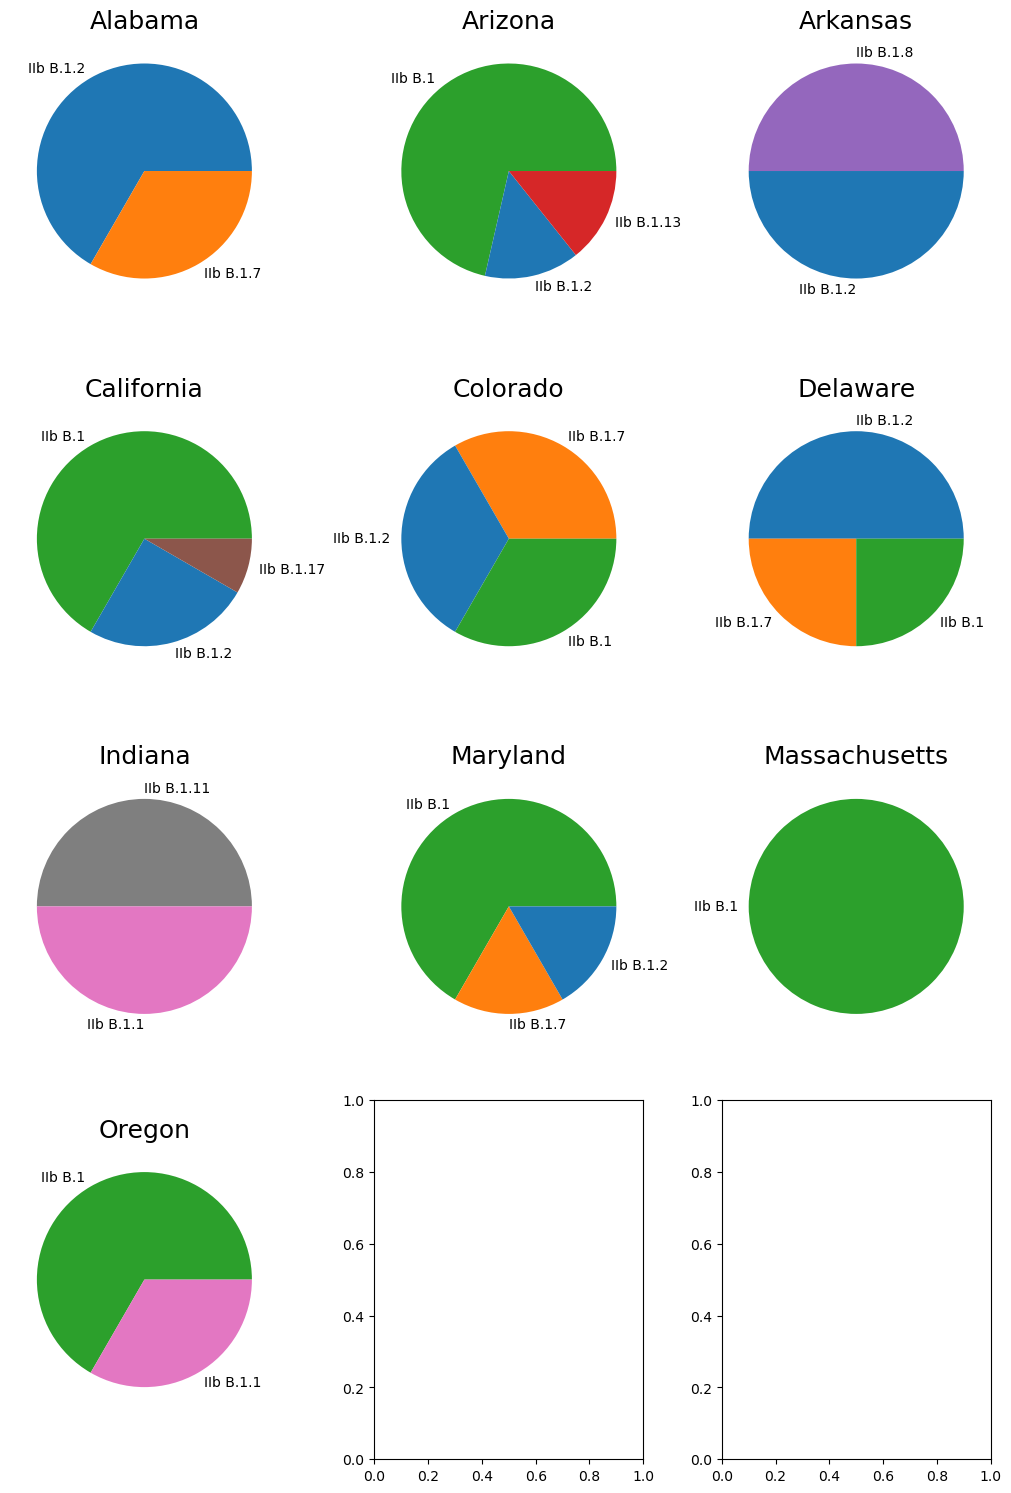

In [8]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(10, 15), layout="constrained")
state_idx = 0
for row in range(4):
    for col in range(3):
        if row == 3 and col > 0:
            continue
        data = lineage_counts.iloc[state_idx]
        axs[row, col].pie(data["Counts"], labels=data["Lineage"], colors=data["Colors"])
        axs[row, col].set_title(lineage_counts.index[state_idx], size = 18)
        state_idx += 1

# I tried to get this to work, but I couldn't figure out how to overlay the pie charts with the map

In [ ]:
# Load data, select relevant columns, and restrict to continental US
shapefiles = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")
shapefiles = shapefiles[["NAME", "geometry"]]
shapefiles = shapefiles[~shapefiles["NAME"].isin(["Puerto Rico", "Alaska", "Hawaii"])]
shapefiles["centroid"] = shapefiles["geometry"].apply(lambda polygon: polygon.centroid)
shapefiles = shapefiles.set_index("NAME")
# shapefiles["centroid"].apply(lambda point: point, result_type="expand")
shapefiles

# shapefiles
# dir(shapefiles["centroid"][0])
# shapefiles["centroid"][0].coords

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 30))
shapefiles.plot(color="lightgrey", edgecolor="darkgrey", figsize=(20,30))
plt.show()
x, y = [point.x for point in shapefiles["centroid"]], [point.y for point in shapefiles["centroid"]]
minx, miny, *_ = shapefiles["geometry"].bounds.min().astype(int)
*_, maxx, maxy = shapefiles["geometry"].bounds.max().astype(int)+1
 
gs = gspec.GridSpec(maxy-miny, maxx-minx)
# dir(gs)

grouped_states = lineage_data.value_counts(["State", "Lineage"]).reset_index()
grouped_states = grouped_states.groupby("State").agg(list)
for state, (labels, counts) in grouped_states.iterrows():
    point = shapefiles.loc[state]["centroid"]
    print(point.x)
    print(point.y)
    x, y = round(point.x)-minx, round(point.y)-miny
    ax = plt.subplot(gs[y:y+5, x:x+5])
    ax.pie(lineage_counts.loc[state]["Counts"], labels=lineage_counts.loc[state]["Counts"])
    
plt.show()
    
    # plt.pie(counts)
# counts = lineage_data["Lineage"].value_counts()

plt.scatter(x, y)